# In Codice Ratio Convolutional Neural Network - Test (with distortions)

## Imports

In [1]:
import os.path
from IPython.display import Image

from util import Util
u = Util()

import numpy as np
# Explicit random seed for reproducibility
np.random.seed(1337)  

Using TensorFlow backend.


In [2]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [3]:
import dataset_generator as dataset

char = 'a'
char_type = 'centrato'

## Definitions

In [4]:
batch_size = 512
nb_classes = 2
nb_epoch = 800
# checkpoint path
checkpoints_filepath = "checkpoints/06_ICR_A_dist_weights.best.hdf5"

In [5]:
# input image dimensions
img_rows, img_cols = 34, 56
# number of convolutional filters to use
nb_filters1 = 30
nb_filters2 = 50
# size of pooling area for max pooling
pool_size1 = (2, 2)
pool_size2 = (3, 3)
# convolution kernel size
kernel_size1 = (4, 4)
kernel_size2 = (5, 5)
# dense layer size
dense_layer_size1 = 250
# dropout rate
dropout = 0.15
# activation
activation = 'relu'

## Data load

In [6]:
(X_train, y_train, X_test, y_test) = dataset.generate_half_labeled_half_height(char, char_type)

Trovati 1638 esempi positivi per il carattere A .
Campioni di training: 1404 	Campioni di test: 234
Richiesti 1638 esempi negativi: trovati 819 generici e 819 per altezza.
Samples negativi generici in training: 702 	in test: 117
Samples negativi per altezza in training: 702 	in test: 117
Campioni di training: 1404 	Campioni di test: 234
Numero totale di campioni di training: 2808
Numero totale di campioni di test: 468


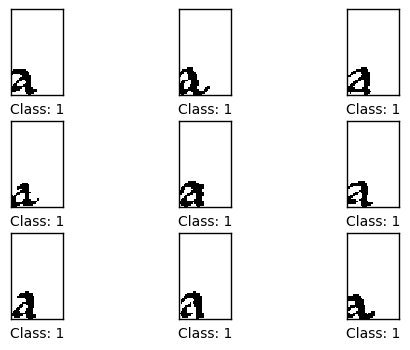

In [7]:
u.plot_images(X_train[0:9], y_train[0:9], img_shape=(56,34))

In [8]:
if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (2808, 34, 56, 1)
2808 train samples
468 test samples


In [10]:
# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Image preprocessing

In [11]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=False)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train)

## Model definition

In [12]:
model = Sequential()

def initialize_network(model, dropout1=dropout, dropout2=dropout):
    model.add(Convolution2D(nb_filters1, kernel_size1[0], kernel_size1[1],
                            border_mode='valid',
                            input_shape=input_shape, name='covolution_1_' + str(nb_filters1) + '_filters'))
    model.add(Activation(activation, name='activation_1_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size1, name='max_pooling_1_' + str(pool_size1) + '_pool_size'))
    model.add(Convolution2D(nb_filters2, kernel_size2[0], kernel_size2[1]))
    model.add(Activation(activation, name='activation_2_' + activation))
    model.add(MaxPooling2D(pool_size=pool_size2, name='max_pooling_1_' + str(pool_size2) + '_pool_size'))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(dense_layer_size1, name='fully_connected_1_' + str(dense_layer_size1) + '_neurons'))
    model.add(Activation(activation, name='activation_3_' + activation))
    model.add(Dropout(dropout))
    model.add(Dense(nb_classes, name='output_' + str(nb_classes) + '_neurons'))
    model.add(Activation('softmax', name='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy', 'precision', 'recall'])
    
    # loading weights from checkpoints 
    if os.path.exists(checkpoints_filepath):
        model.load_weights(checkpoints_filepath)
    
initialize_network(model)

## Training and evaluation
Using non verbose output for training, since we already get some informations from the callback. 

In [13]:
# checkpoint
checkpoint = ModelCheckpoint(checkpoints_filepath, monitor='val_precision', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
# fits the model on batches with real-time data augmentation, for nb_epoch-100 epochs
history = model.fit_generator(datagen.flow(X_train, Y_train, 
                                           batch_size=batch_size, 
                                          # save_to_dir='distorted_data', 
                                          # save_format='png'
                                           seed=1337),
                              samples_per_epoch=len(X_train), nb_epoch=nb_epoch-50, verbose=0, 
                              validation_data=(X_test, Y_test), callbacks=callbacks_list)

# ensures that the weights with the best evaluation are loaded
if os.path.exists(checkpoints_filepath):
    model.load_weights(checkpoints_filepath)

Epoch 00000: val_precision improved from -inf to 0.94017, saving model to checkpoints/05_ICR_A_dist_weights.best.hdf5
Epoch 00001: val_precision improved from 0.94017 to 0.94658, saving model to checkpoints/05_ICR_A_dist_weights.best.hdf5
Epoch 00002: val_precision did not improve
Epoch 00003: val_precision improved from 0.94658 to 0.95085, saving model to checkpoints/05_ICR_A_dist_weights.best.hdf5
Epoch 00004: val_precision did not improve
Epoch 00005: val_precision did not improve
Epoch 00006: val_precision did not improve
Epoch 00007: val_precision did not improve
Epoch 00008: val_precision did not improve
Epoch 00009: val_precision did not improve
Epoch 00010: val_precision did not improve
Epoch 00011: val_precision did not improve
Epoch 00012: val_precision did not improve
Epoch 00013: val_precision did not improve
Epoch 00014: val_precision did not improve
Epoch 00015: val_precision did not improve
Epoch 00016: val_precision did not improve
Epoch 00017: val_precision did not imp

In [15]:
# training
history_cont = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=50,
          verbose=0, validation_data=(X_test, Y_test), callbacks=callbacks_list)

# ensures that the weights with the best evaluation are loaded
if os.path.exists(checkpoints_filepath):
    model.load_weights(checkpoints_filepath)

Epoch 00000: val_precision did not improve
Epoch 00001: val_precision did not improve
Epoch 00002: val_precision did not improve
Epoch 00003: val_precision did not improve
Epoch 00004: val_precision did not improve
Epoch 00005: val_precision did not improve
Epoch 00006: val_precision improved from 0.96581 to 0.96795, saving model to checkpoints/05_ICR_A_dist_weights.best.hdf5
Epoch 00007: val_precision did not improve
Epoch 00008: val_precision did not improve
Epoch 00009: val_precision did not improve
Epoch 00010: val_precision did not improve
Epoch 00011: val_precision did not improve
Epoch 00012: val_precision did not improve
Epoch 00013: val_precision did not improve
Epoch 00014: val_precision did not improve
Epoch 00015: val_precision did not improve
Epoch 00016: val_precision did not improve
Epoch 00017: val_precision did not improve
Epoch 00018: val_precision did not improve
Epoch 00019: val_precision did not improve
Epoch 00020: val_precision did not improve
Epoch 00021: val_pr

In [16]:
# evaluation
print('evaluating model')
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1]*100, '%')
print('Test error:', (1-score[2])*100, '%')

evaluating model
468/468 [==============================] - 0s     
Test score: 0.144882577822
Test accuracy: 96.7948717949 %
Test error: 3.20512820513 %


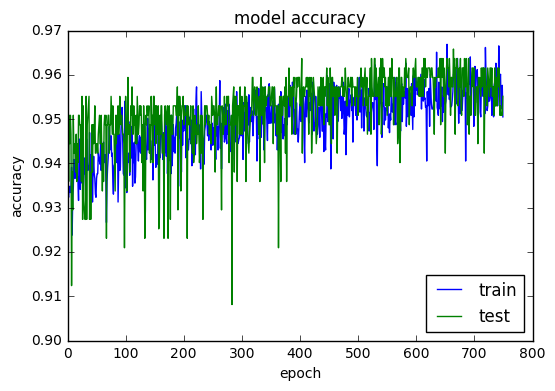

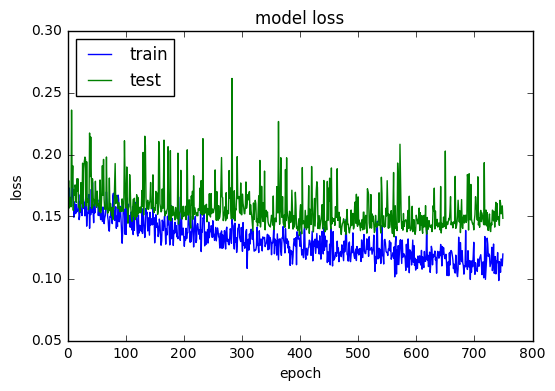

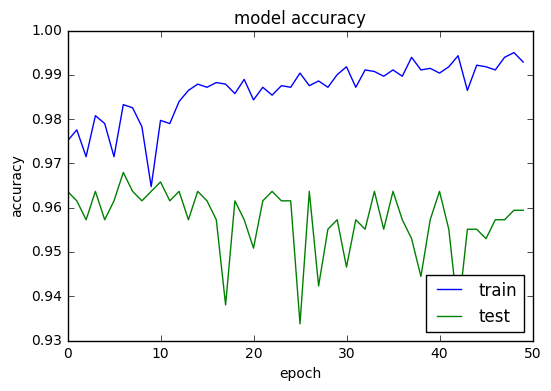

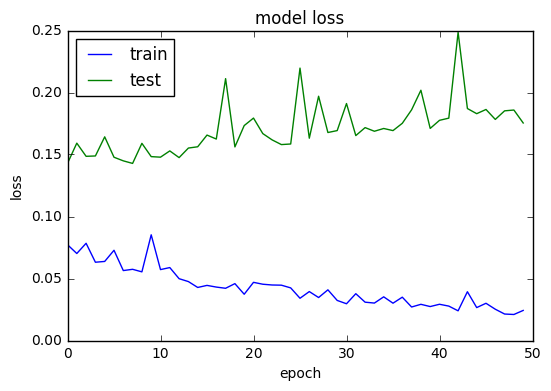

In [17]:
u.plot_history(history)
u.plot_history(history, metric='loss', loc='upper left')

u.plot_history(history_cont)
u.plot_history(history_cont, metric='loss', loc='upper left')

## Inspecting the result

In [18]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = model.predict_classes(X_test)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

416/468 [=========================>....] - ETA: 0s

### Examples of correct predictions

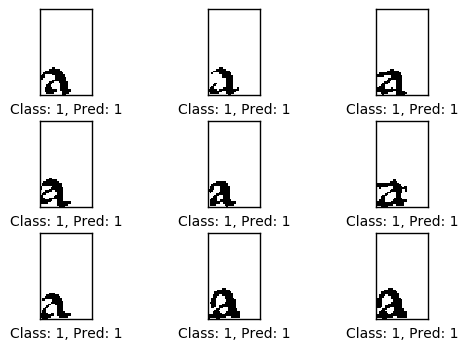

In [19]:
u.plot_images(X_test[correct_indices[:9]], y_test[correct_indices[:9]], 
              predicted_classes[correct_indices[:9]], img_shape=(56,34))

### Examples of incorrect predictions

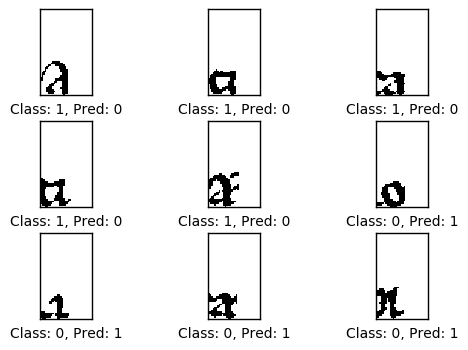

In [20]:
u.plot_images(X_test[incorrect_indices[:9]], y_test[incorrect_indices[:9]], 
              predicted_classes[incorrect_indices[:9]], img_shape=(56,34))

### Confusion matrix

[[224  10]
 [  5 229]]


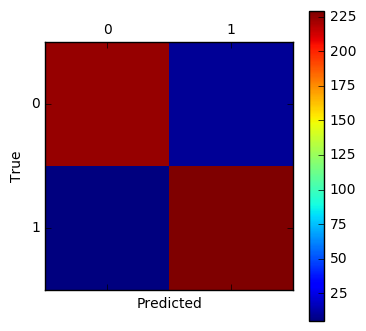

In [21]:
u.plot_confusion_matrix(y_test, nb_classes, predicted_classes)

## Results